## 2. Stereo Vision

### 2.2. Epipolar Geometry

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Pair of images used
# http://vision.middlebury.edu/stereo/data/scenes2014/datasets/Recycle-perfect/

# Read left and right stereo image-pair (in RGB)
img_left = cv2.cvtColor(cv2.imread('./img_left.png'), cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(cv2.imread('./img_right.png'), cv2.COLOR_BGR2RGB)

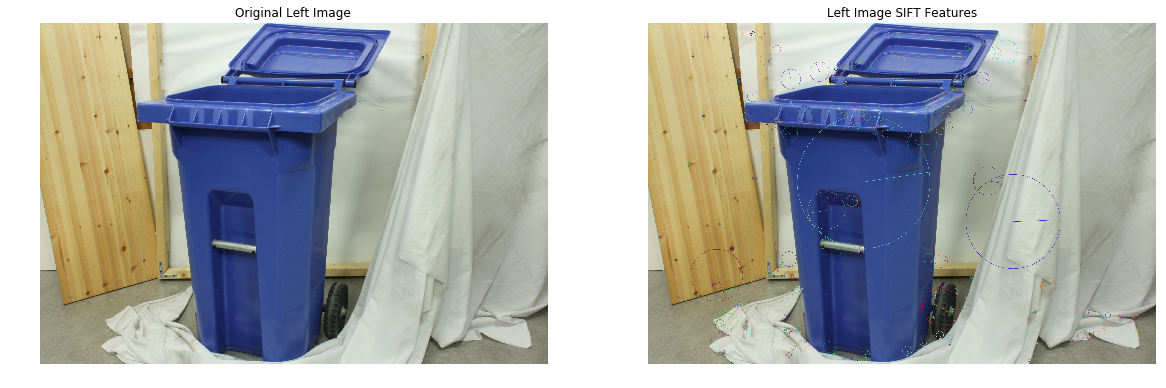

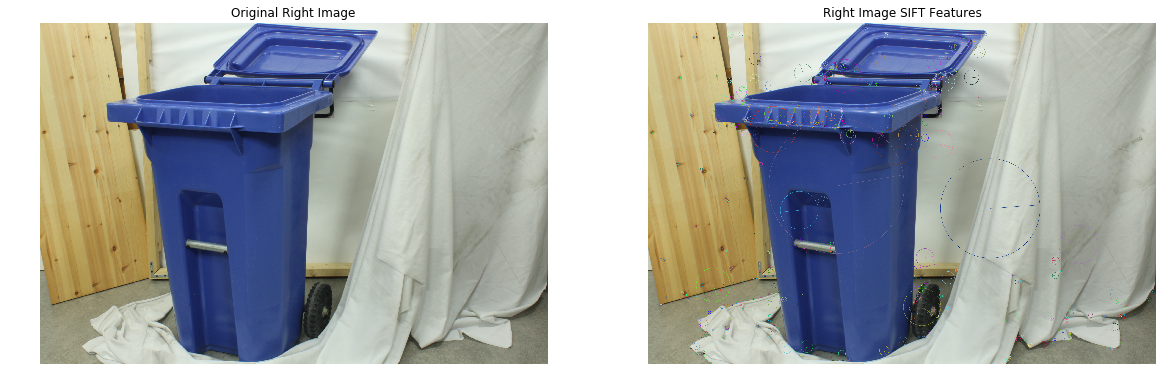

In [3]:
# Create image-pair copies
img_left_sift = img_left.copy()
img_right_sift = img_right.copy()

# Detect SIFT features and compute its descriptors
sift = cv2.xfeatures2d.SIFT_create()
img_left_kp, img_left_desc = sift.detectAndCompute(img_left, None)
img_right_kp, img_right_desc = sift.detectAndCompute(img_right, None)

# Draw the keypoints on the image-pair copies
kp_flag = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
cv2.drawKeypoints(img_left, img_left_kp, img_left_sift, flags=kp_flag)
cv2.drawKeypoints(img_right, img_right_kp, img_right_sift, flags=kp_flag)

# Display left SIFT features and descriptors plot
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img_left)
plt.title('Original Left Image'), plt.axis('off')
plt.subplot(122), plt.imshow(img_left_sift)
plt.title('Left Image SIFT Features'), plt.axis('off')
plt.show()

# Display right SIFT features and descriptors plot
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img_right)
plt.title('Original Right Image'), plt.axis('off')
plt.subplot(122), plt.imshow(img_right_sift)
plt.title('Right Image SIFT Features'), plt.axis('off')
plt.show()

Total number of keypoints in img_left: 293
Total number of keypoints in img_right: 293
Total number of bad keypoints in img_left: 567
Total number of bad keypoints in img_right: 567
Total number of matches: 860


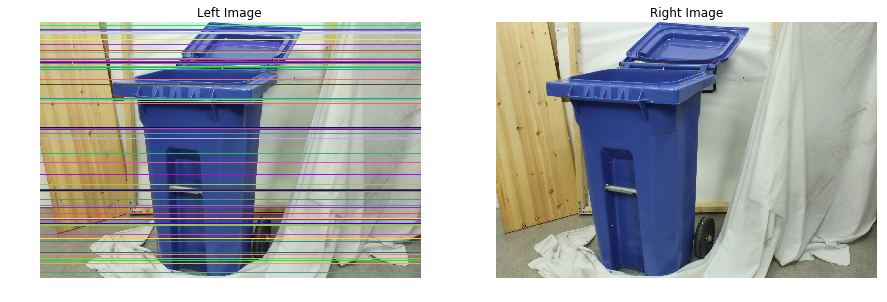

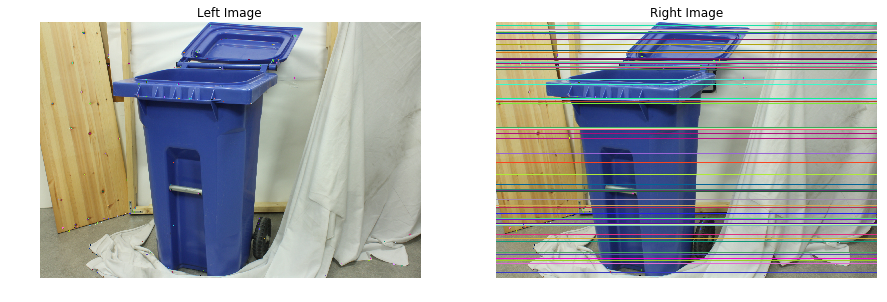

In [4]:
def getPointOnLine(line, x):
    """
    :param line: Line of format ax+by+c=0
    :param x: Value of x axis
    :return: Tuple with x, y coordinates
    """

    a, b, c = line
    return (x, int(round(-(a*x+c)/b)))

def drawLines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in
    the first image are drawn on the second image.
    :param img1: Draw epilines for the points in img2 on image
    :param lines: Corresponding epilines
    :return: Images with epilines drawn
    """

    h, w, _ = img1.shape
    img1 = img1.copy()
    img2 = img2.copy()

    # For each line (ax+by+c=0)
    for line, pt1, pt2 in zip(lines, pts1, pts2):
        # Start and end points
        x0, y0 = getPointOnLine(line, 0)
        x1, y1 = getPointOnLine(line, w)

        # Draw the lines and the points
        color = tuple(np.random.randint(0, 255, 3).tolist())
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 2)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

# Find the 2 best keypoint matches per descriptor for the image-pair
matches = cv2.BFMatcher(cv2.NORM_L2).knnMatch(img_left_desc, img_right_desc, k=2)

# Ratio test to store the best matches from both images
pts_l, pts_r = [], []
pts_l_bad, pts_r_bad = [], []
for m, n in matches:
    if m.distance < 0.6 * n.distance:
        pts_l.append(img_left_kp[m.queryIdx].pt)
        pts_r.append(img_right_kp[m.trainIdx].pt)
    else:
        pts_l_bad.append(img_left_kp[m.queryIdx].pt)
        pts_r_bad.append(img_right_kp[m.trainIdx].pt)

pts_l = np.int32(pts_l)
pts_r = np.int32(pts_r)
pts_l_bad = np.int32(pts_l_bad)
pts_r_bad = np.int32(pts_r_bad)

# Print number of matching keypoints
print('Total number of keypoints in img_left:', len(pts_l))
print('Total number of keypoints in img_right:', len(pts_r))
print('Total number of bad keypoints in img_left:', len(pts_l_bad))
print('Total number of bad keypoints in img_right:', len(pts_r_bad))
print('Total number of matches:', len(matches))

# Find the Fundamental Matrix
fm, mask = cv2.findFundamentalMat(pts_l, pts_r, cv2.FM_LMEDS)

# Use only inliers for remaining computations
pts_l = pts_l[mask.ravel() == 1]
pts_r = pts_r[mask.ravel() == 1]

# Epilines corresponding to points in the first image is drawn on the second image
lines_left = cv2.computeCorrespondEpilines(pts_r, 2, fm).reshape(-1, 3)
img_left_lines_1, img_right_lines_1 = drawLines(img_left, img_right, lines_left, pts_l, pts_r)

# Epilines corresponding to points in the first image is drawn on the second image
lines_right = cv2.computeCorrespondEpilines(pts_l, 1, fm).reshape(-1, 3)
img_right_lines_2, img_left_lines_2 = drawLines(img_right, img_left, lines_right, pts_r, pts_l)

# Display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_left_lines_1)
plt.title('Left Image'), plt.axis('off')
plt.subplot(122), plt.imshow(img_right_lines_1)
plt.title('Right Image'), plt.axis('off')
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_left_lines_2)
plt.title('Left Image'), plt.axis('off')
plt.subplot(122), plt.imshow(img_right_lines_2)
plt.title('Right Image'), plt.axis('off')
plt.show()

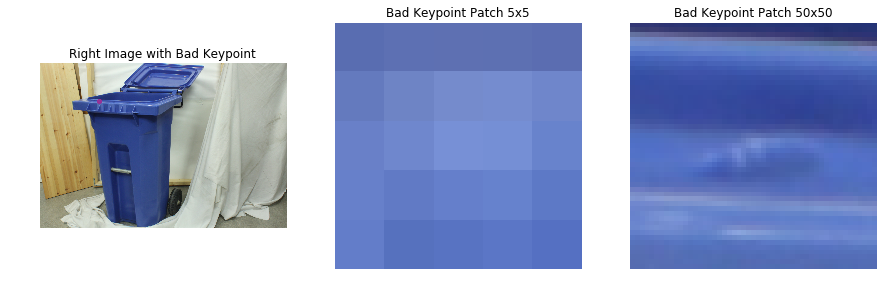

In [5]:
def getPatch(img, pt, size):
    """
    :param img: Image to get the patch
    :param pt: Center point on image to get patch
    :param size: 2D list indicating the patch size
    :return: Patch of specified size around the center point
    """

    x, y = pt
    hs, ws = size
    h, w, _ = img.shape

    x_s = max(x - ws//2, 0)
    x_e = min(x + ws//2 + 1, w - 1)
    y_s = max(y - hs//2, 0)
    y_e = min(y + hs//2 + 1, h - 1)

    return img[y_s:y_e, x_s:x_e]

def getPatchesOnLine(img, line, size):
    """
    :param img: Image to get the patches
    :param line: Line with list of formula parameters (ax+by+c=0)
    :param size: 2D list indicating the patch size
    :return: List of patches of specified size following the line
    """

    patches = []
    _, w, d = img.shape
    for x in range(w):
        patch = getPatch(img, getPointOnLine(line, x), size)
        if patch.shape == (*size, d):
            patches.append(patch)

    return patches

# Pick 5x5 patch around worst keypoint in right image which doesn’t have
# correct match in left image and isn't on epipolar line
idx = 5
patch_size = (5, 5)
patch_big_size = (50, 50)
pt_r_bad = pts_r_bad[idx]
patch = getPatch(img_right, pt_r_bad, patch_size)
patch_big = getPatch(img_right, pt_r_bad, patch_big_size)
img_patch = cv2.circle(img_right.copy(), tuple(pt_r_bad), 30, (150, 50, 150), -1)

# Display images
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(img_patch)
plt.title('Right Image with Bad Keypoint'), plt.axis('off')
plt.subplot(132), plt.imshow(patch)
plt.title('Bad Keypoint Patch 5x5'), plt.axis('off')
plt.subplot(133), plt.imshow(patch_big)
plt.title('Bad Keypoint Patch 50x50'), plt.axis('off')
plt.show()

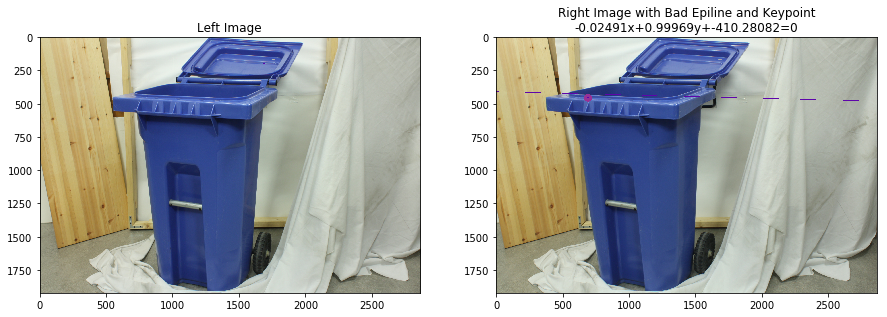

In [6]:
# Compare every line in left image to find point and line to use
# Find the Fundamental Matrix
fm, mask = cv2.findFundamentalMat(pts_l_bad, pts_r_bad, cv2.FM_LMEDS)

# Bad epiline corresponding to bad point in the right image is drawn on the right image
line_left_bad = cv2.computeCorrespondEpilines(pts_r_bad[idx:idx+1], 2, fm).reshape(-1, 3)
img_right_line_bad, img_left_line_bad = drawLines(img_patch, img_left, line_left_bad, pts_r_bad[idx:idx+1], pts_l_bad[idx:idx+1])

# Display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(img_left_line_bad)
plt.title('Left Image')
plt.subplot(122), plt.imshow(img_right_line_bad)
plt.title('Right Image with Bad Epiline and Keypoint\n{}x+{}y+{}=0'.format(*[round(float(x), 5) for x in line_left_bad[0]]))
plt.show()

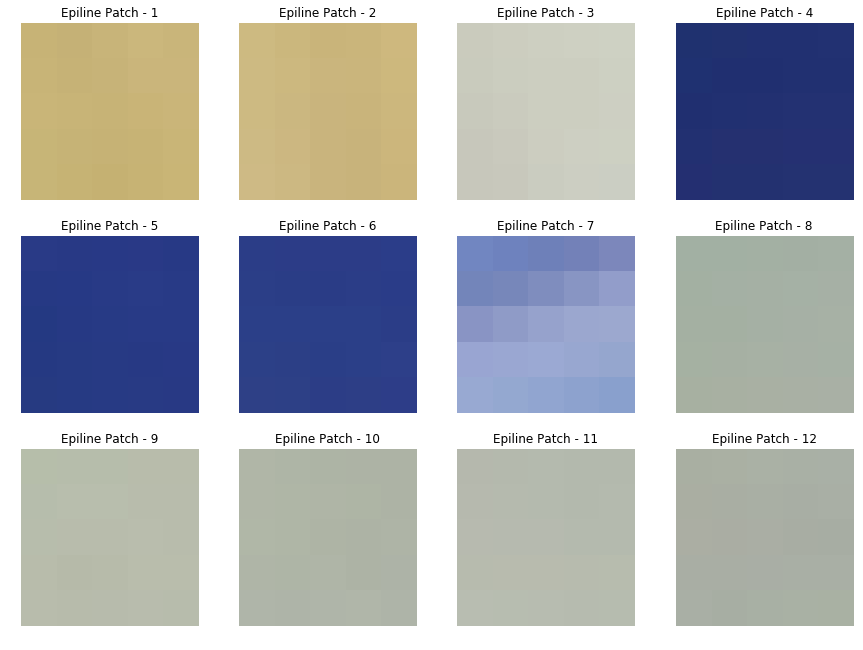

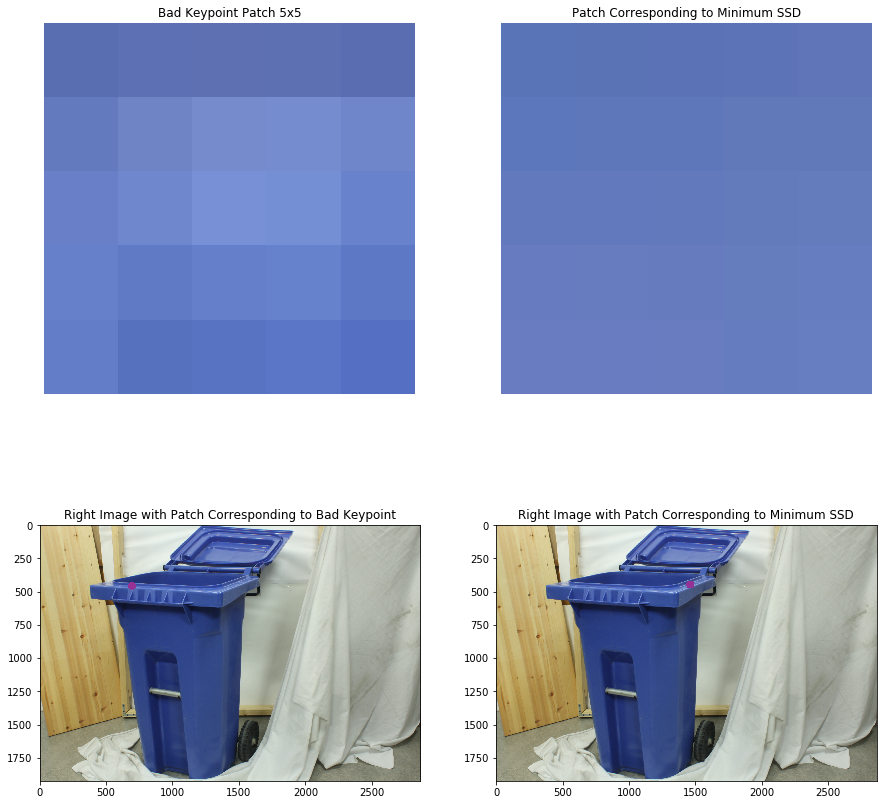

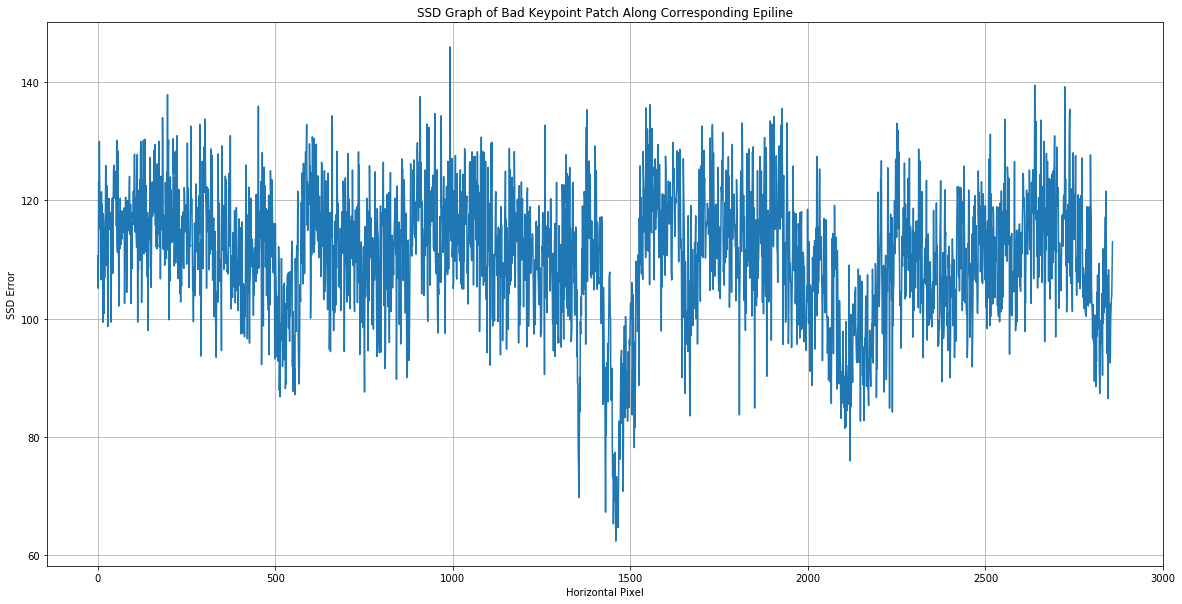

In [7]:
def plotFigures(images, title, size=4):
    """
    :param images: List of images to plot
    :param title: Title to give to the figures
    :param size: Width size of the grid
    """

    plt.figure(figsize=(15, 15))
    for i, image in enumerate(images, 1):
        plt.subplot(size, size, i), plt.imshow(image)
        plt.title('{} - {}'.format(title, i)), plt.axis('off')
    plt.show()

def getSSD(patch, patches):
    """
    :param patch: Patch to compare against other patches
    :param patches: List of patches to be compared to
    :return: List of SSDs, Minimum SSD, Index of minimum SSD
    """

    ssd = []
    for p in patches:
        sq_diff = (patch - p) ** 2
        ssd.append(np.mean(sq_diff))

    min_ssd = min(ssd)
    return ssd, min_ssd, ssd.index(min_ssd)

# Get all patches along the epiline associated to the bad keypoint
line_patches = getPatchesOnLine(img_right, line_left_bad[0], patch_size)
ssd, min_ssd, min_ssd_idx = getSSD(patch, line_patches)

img_patch_ssd = cv2.circle(img_right.copy(), getPointOnLine(line_left_bad[0], min_ssd_idx), 30, (150, 50, 150), -1)

# Plot a few patches along the epiline
plotFigures(line_patches[:4000:250], 'Epiline Patch')

# Display the patch from the bad keypoint and min SSD patch
plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(patch)
plt.title('Bad Keypoint Patch 5x5'), plt.axis('off')
plt.subplot(222), plt.imshow(line_patches[min_ssd_idx])
plt.title('Patch Corresponding to Minimum SSD'), plt.axis('off')

# Display the patches on the right image from the bad keypoint and min SSD
plt.subplot(223), plt.imshow(img_patch)
plt.title('Right Image with Patch Corresponding to Bad Keypoint')
plt.subplot(224), plt.imshow(img_patch_ssd)
plt.title('Right Image with Patch Corresponding to Minimum SSD')

# Display SSD map
plt.figure(figsize=(20,10))
plt.plot(ssd), plt.grid(True), plt.xlabel('Horizontal Pixel'), plt.ylabel('SSD Error')
plt.title('SSD Graph of Bad Keypoint Patch Along Corresponding Epiline')
plt.show()

**Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one?**

From the list of SSD points, I found one matching point using the lowest SSD value, although it is not the correct one seeing as the coordinates are completely off.

In my case, the issue is that the recycling bin has a very uniform pattern. Also, since we are only using a 5x5 patch, there isn't much context to the point when calculating the SSD.

**Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to find a single match?**

One way to improve the accuracy of the matching is to include smoothness when calculating the SSD in order to ensure the disparity within local neighbourhoods.

**Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?**

Like previously mentioned for my case, to improve the correctness of patch matching, we could increase the patch size to give context when calculating the SSD.